In [19]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import pandas as pd

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

%matplotlib ipympl
# %matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [20]:
from importlib import reload
from rfdsppy import calc, ofdm, nonlinear_model

reload(calc)
reload(ofdm)
reload(nonlinear_model)

<module 'rfdsppy.nonlinear_model' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/nonlinear_model.py'>

          Waveform   EVM (%)  SNR (dB)
0  DFT-s-OFDM QPSK  0.373661     48.55


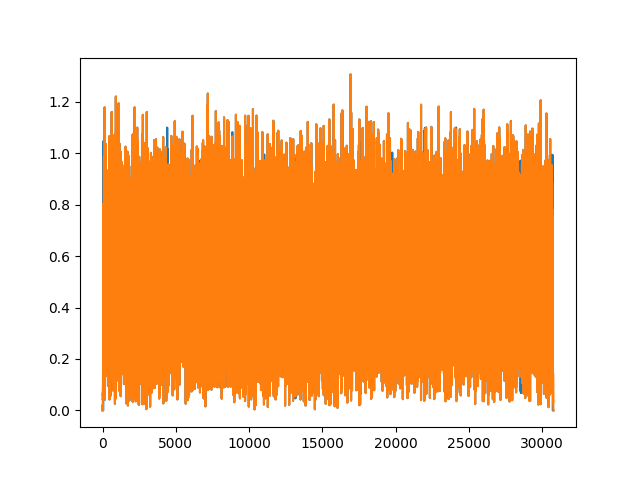

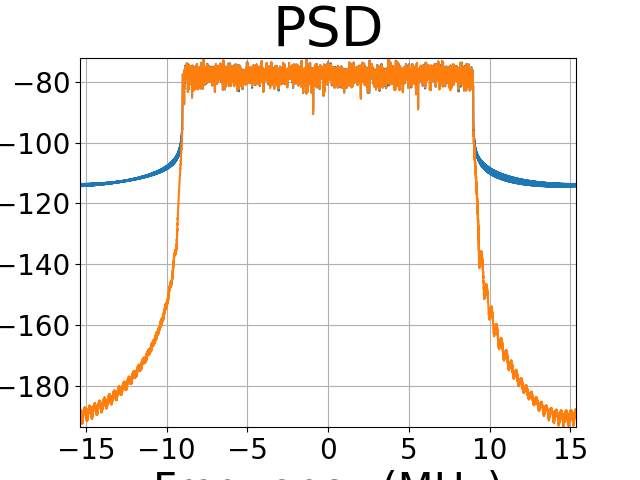

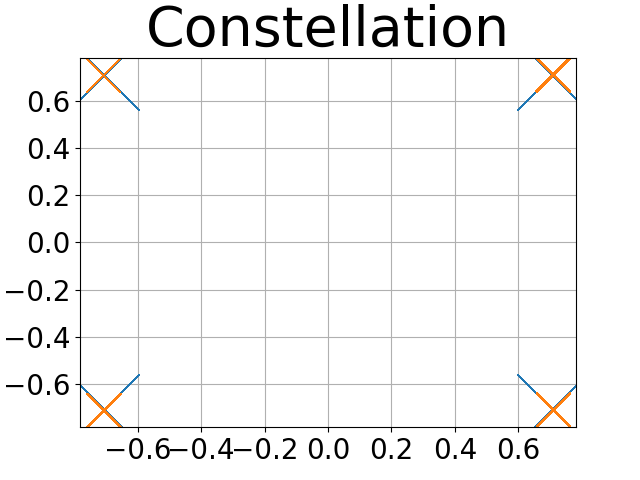

In [23]:
en_td_plot = True
en_psd_plot = True
en_const_plot = True

# Waveform params
en_tprecodes = [True, False] # DFT-s-OFDM, CP-OFDM
en_tprecodes = [True]
modorders = [4, 16, 64, 256]
modorders = [4]
wola = 5
bw = 20
scs = 15

# Sweep waveforms
out = {
    "Waveform": [],
    "EVM (%)": [],
    "SNR (dB)": [],
}
for en_tprecode in en_tprecodes:
    for modorder in modorders:

        # Initialize waveform generator
        wg = ofdm.OFDMWavGen(bw=bw, scs=scs, modorder=modorder, en_tprecode=en_tprecode, wola=wola)

        # Generate waveform
        x, x_standard = wg.generate(nsym=14, seed=0)
        cfg_evm = wg.get_demod_params()
        fs = cfg_evm.get("fs")
        wola_len = cfg_evm.get("wola_len")
        
        # Plot time-domain samples
        if en_td_plot:
            fig = plt.figure()
            plt.plot(np.abs(np.concatenate((np.zeros(round(wg.wola_len/2)), x_standard, np.zeros(round(wg.wola_len/2))))))
            plt.plot(np.abs(x))
        
        # Plot PSDs
        if en_psd_plot:
            rbw = scs/1000/2**2
            p, f = calc.psd(x,fs,rbw)
            ps, f = calc.psd(x_standard,fs,rbw)
            fig = plt.figure()
            plt.plot(f, 10*np.log10(ps))
            plt.plot(f, 10*np.log10(p))
            plt.title("PSD", {'fontsize':40})
            plt.xlabel("Frequency (MHz)", {'fontsize':30})
            plt.ylabel("PSD (dB/Bin)", {'fontsize':30})
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.autoscale(enable=True, axis='both', tight=True)
            plt.grid()
        
        # EVM
        if en_const_plot:
            evm = wg.calculate_evm(x_standard, x[round(wola_len/2):], en_plot=True)
            # evm = ofdm.ofdm_evm_calculator(cfg_evm,x_standard,x[round(wola_len/2):])
            snr = round(-20*np.log10(evm/100),2)
        
        wavstr = 'DFT-s-OFDM ' if en_tprecode == 1 else 'CP-OFDM '
        wavstr = wavstr + 'QPSK' if modorder == 4 else wavstr + str(modorder) + 'QAM'
        out['Waveform'].append(wavstr)
        out['EVM (%)'].append(evm)
        out['SNR (dB)'].append(snr)

out = pd.DataFrame(out)
print(out)